
# Tutorial: Imbalanced Data (ROS, RUS, SMOTE, SMOTE-ENN)

Notebook ini dirancang agar **langsung bisa dijalankan di Jupyter** untuk menyelesaikan tugas Anda tentang *imbalanced data*.
Semua sel sudah diberi **penjelasan rinci** tentang *apa yang dilakukan kode* dan **fungsi tiap library Python** yang digunakan.

> **Checklist Tugas (ringkas):**
> 1) Coba pada dataset berbeda (disediakan contoh *synthetic* & placeholder CSV sendiri)  
> 2) Terapkan: **ROS, RUS, SMOTE, SMOTE-ENN**  
> 3) Buat laporan berformat PDF berisi **screenshot + penjelasan**  
> 4) Kumpulkan file `.py`/`.ipynb` + laporan PDF

---



## 1) Setup Lingkungan & Instalasi Library

Di sel ini kita memasang library yang dibutuhkan:
- `pandas`: manipulasi data tabular
- `numpy`: operasi numerik
- `matplotlib` & `seaborn`: visualisasi
- `scikit-learn`: *modeling* (train/test split, preprocessing, metric, cross-validation, model baseline)
- `imbalanced-learn (imblearn)`: teknik penanganan **imbalanced data** (ROS, RUS, SMOTE, SMOTE-ENN)


In [2]:

# Jika Anda menjalankan di lingkungan baru, *uncomment* baris di bawah ini.
# !pip install -U pandas numpy matplotlib seaborn scikit-learn imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn (modeling & preprocessing)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# imbalanced-learn (penanganan imbalance)
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Library siap.')


Library siap.



## 2) Siapkan Dataset
Anda punya **dua opsi**:

**Opsi A — Gunakan file CSV Anda sendiri**  
- Ganti `your_dataset.csv` menjadi path dataset Anda.
- Ganti `target_col` dengan nama kolom target biner (0/1).

**Opsi B — Buat *synthetic dataset***  
- Jika belum punya dataset, jalankan sel *synthetic* untuk membuat data tidak seimbang (minoritas 10%).

> Notebook ini juga otomatis mendeteksi kolom kategorikal vs numerik dan melakukan imputasi + encoding via `ColumnTransformer`.


In [3]:

# === Opsi A: Muat CSV Anda sendiri ===
# TODO: ganti path & target
CSV_PATH  = "your_dataset.csv"    # <-- Ganti ke file Anda (mis: 'titanicEdit.csv')
target_col = "Survived"           # <-- Ganti sesuai nama kolom target Anda

use_csv = False  # ubah ke True jika ingin memuat CSV Anda

if use_csv:
    df = pd.read_csv(CSV_PATH)
    df.columns = df.columns.str.strip()
    if target_col not in df.columns:
        raise ValueError(f"Kolom target '{target_col}' tidak ditemukan.")
    print("Preview data (CSV):")
    display(df.head())
else:
    print("Lewati Opsi A (CSV). Lanjut ke Opsi B (Synthetic) di sel berikut.")


Lewati Opsi A (CSV). Lanjut ke Opsi B (Synthetic) di sel berikut.


In [4]:

# === Opsi B: Synthetic dataset (untuk contoh jika belum punya CSV) ===
from sklearn.datasets import make_classification

make_synth = True  # set False jika Anda sudah memakai CSV

if make_synth:
    X, y = make_classification(
        n_samples=5000,
        n_features=12,
        n_informative=6,
        n_redundant=2,
        n_repeated=0,
        n_classes=2,
        weights=[0.9, 0.1],   # 90% kelas 0 (mayoritas), 10% kelas 1 (minoritas)
        class_sep=1.2,
        random_state=RANDOM_STATE
    )
    df = pd.DataFrame(X, columns=[f"feat_{i}" for i in range(X.shape[1])])
    df["target"] = y
    target_col = "target"
    print("Preview data (Synthetic):")
    display(df.head())


Preview data (Synthetic):


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,target
0,-2.648885,-4.845461,4.370271,-0.452805,-0.523299,-2.641781,-3.650963,-2.742701,1.281397,-0.458710,1.478187,-0.501279,0
1,-1.277684,-1.857585,4.829865,-4.067030,-0.023494,-3.116986,1.596906,-0.664893,-0.067128,-0.049087,1.001420,0.714309,0
2,0.429683,-1.679634,2.377206,-3.246619,-0.544627,-3.033527,0.530576,-2.676280,0.200603,0.757701,-0.533243,-0.383821,0
3,-2.861743,-7.256553,4.989088,-3.277125,0.336875,-0.363940,-2.191883,1.245626,0.423103,-0.873257,0.258710,-0.952093,0
4,-0.933960,-3.245839,-1.927467,1.697519,0.236156,5.591917,-2.144944,3.349850,-0.659016,1.128489,-0.845698,0.703724,0



## 3) EDA Singkat: Cek Ketidakseimbangan
Kita hitung distribusi kelas target, *missing values*, serta tipe data kolom.


Distribusi Kelas (label -> jumlah):
 target
0    4479
1     521
Name: count, dtype: int64


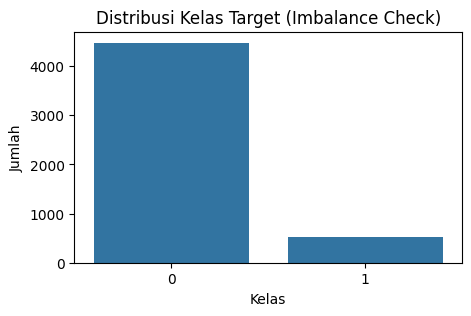


Missing values per kolom:
 feat_0     0
feat_1     0
feat_2     0
feat_3     0
feat_4     0
feat_5     0
feat_6     0
feat_7     0
feat_8     0
feat_9     0
feat_10    0
feat_11    0
target     0
dtype: int64

Kolom numerik  : ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11']
Kolom kategorik: []


In [5]:

# Cek distribusi kelas target
counts = df[target_col].value_counts(dropna=False).sort_index()
print("Distribusi Kelas (label -> jumlah):\n", counts)

plt.figure(figsize=(5,3))
sns.barplot(x=counts.index.astype(str), y=counts.values)
plt.title("Distribusi Kelas Target (Imbalance Check)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

# Missing values
print("\nMissing values per kolom:\n", df.isna().sum())

# Pisahkan fitur & target
X = df.drop(columns=[target_col])
y = df[target_col]

# Deteksi kolom numerik/kategorikal untuk preprocessing otomatis
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))
print(f"\nKolom numerik  : {num_cols}")
print(f"Kolom kategorik: {cat_cols}")



## 4) Preprocessing Otomatis (Imputasi, Encoding, Scaling)

- **Numerik**: `SimpleImputer(strategy="median")` + `StandardScaler()`  
- **Kategorikal**: `SimpleImputer(strategy="most_frequent")` + `OneHotEncoder(handle_unknown="ignore")`

Kita bungkus menjadi `ColumnTransformer`, lalu dipakai di *pipeline*.


In [6]:

numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler" , StandardScaler())
])

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe"    , OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
], remainder="drop")

print("Preprocessing siap.")


Preprocessing siap.



## 5) Baseline Tanpa Penanganan Imbalance

Kita latih model **Logistic Regression** pada *train set* **tanpa** oversampling/undersampling.
Lalu evaluasi dengan:
- `classification_report`
- `confusion_matrix`
- `roc_auc_score` (AUC)
- Skor **cross-val StratifiedKFold** untuk gambaran stabilitas.


=== Baseline (No Resampling) ===
              precision    recall  f1-score   support

           0     0.9199    0.9839    0.9508      1120
           1     0.6538    0.2615    0.3736       130

    accuracy                         0.9088      1250
   macro avg     0.7869    0.6227    0.6622      1250
weighted avg     0.8922    0.9088    0.8908      1250

ROC-AUC: 0.8749519230769232


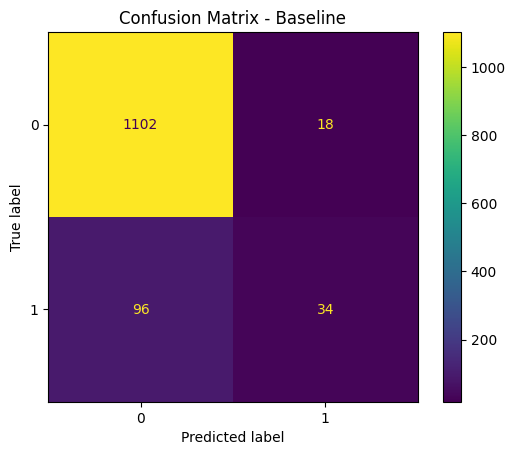

CV ROC-AUC: [0.87955014 0.86609289 0.87858431 0.83838427 0.8975153 ]  | Mean: 0.8720253807528598


In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

baseline = Pipeline([
    ("prep", preprocess),
    ("clf" , LogisticRegression(max_iter=1000, class_weight=None, random_state=RANDOM_STATE))
])

baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
y_pred_proba = baseline.predict_proba(X_test)[:,1]

print("=== Baseline (No Resampling) ===")
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - Baseline")
plt.show()

# Cross-validated ROC-AUC (lebih stabil)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(baseline, X, y, cv=cv, scoring="roc_auc")
print("CV ROC-AUC:", cv_scores, " | Mean:", cv_scores.mean())



## 6) Penanganan Imbalance: ROS, RUS, SMOTE, SMOTE-ENN

**Penjelasan singkat tiap metode:**
- **ROS (RandomOverSampler)**: menggandakan contoh kelas minoritas secara acak.
- **RUS (RandomUnderSampler)**: mengurangi contoh kelas mayoritas secara acak.
- **SMOTE**: *Synthetic Minority Over-sampling Technique*; membuat sampel **sintetis** di sekitar *neighbor* kelas minoritas.
- **SMOTE-ENN**: gabungan SMOTE + **Edited Nearest Neighbours** (ENN) untuk *clean-up* sampel yang ambigu/noisy setelah oversampling.

Kita gunakan `ImbPipeline` agar **resampling terjadi *hanya* pada data latih** di dalam CV dan menghindari *data leakage*.



=== ROS (RandomOverSampler) ===
              precision    recall  f1-score   support

           0     0.9748    0.7946    0.8756      1120
           1     0.3175    0.8231    0.4582       130

    accuracy                         0.7976      1250
   macro avg     0.6462    0.8089    0.6669      1250
weighted avg     0.9064    0.7976    0.8322      1250

ROC-AUC: 0.8766414835164835


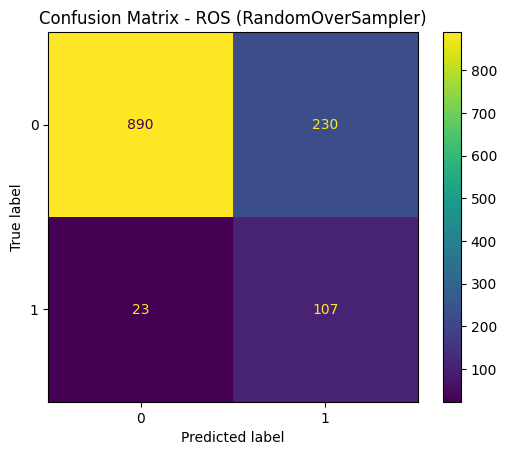

CV ROC-AUC: [0.88122424 0.8643544  0.88415393 0.84659384 0.89466347]  | Mean: 0.8741979764590624

=== RUS (RandomUnderSampler) ===
              precision    recall  f1-score   support

           0     0.9756    0.7848    0.8699      1120
           1     0.3095    0.8308    0.4509       130

    accuracy                         0.7896      1250
   macro avg     0.6425    0.8078    0.6604      1250
weighted avg     0.9063    0.7896    0.8263      1250

ROC-AUC: 0.8784478021978023


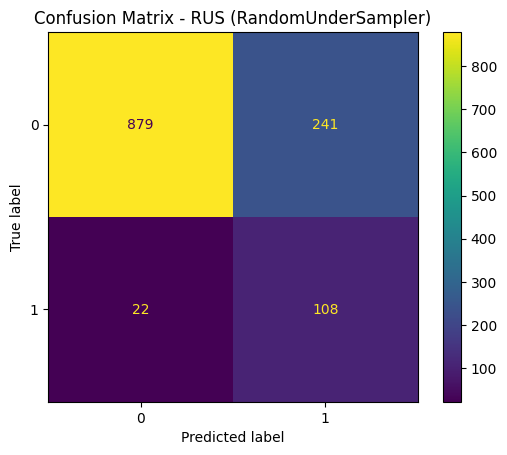

CV ROC-AUC: [0.88360663 0.86583534 0.88580658 0.84200077 0.89402501]  | Mean: 0.8742548639675036

=== SMOTE ===
              precision    recall  f1-score   support

           0     0.9740    0.8027    0.8801      1120
           1     0.3242    0.8154    0.4639       130

    accuracy                         0.8040      1250
   macro avg     0.6491    0.8090    0.6720      1250
weighted avg     0.9064    0.8040    0.8368      1250

ROC-AUC: 0.8777953296703298


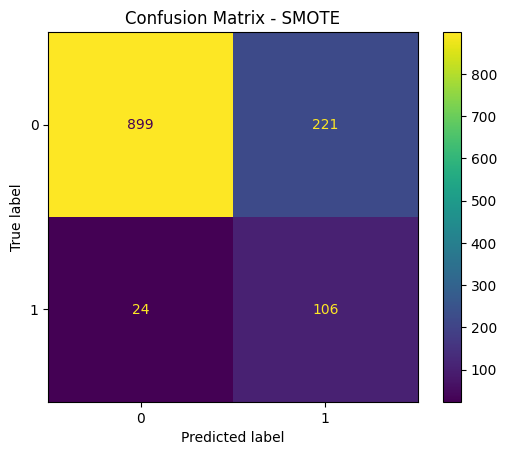

CV ROC-AUC: [0.88270519 0.86622167 0.88437929 0.84582117 0.89293961]  | Mean: 0.874413385918667

=== SMOTE-ENN ===
              precision    recall  f1-score   support

           0     0.9813    0.7491    0.8496      1120
           1     0.2886    0.8769    0.4343       130

    accuracy                         0.7624      1250
   macro avg     0.6349    0.8130    0.6420      1250
weighted avg     0.9092    0.7624    0.8064      1250

ROC-AUC: 0.8779395604395606


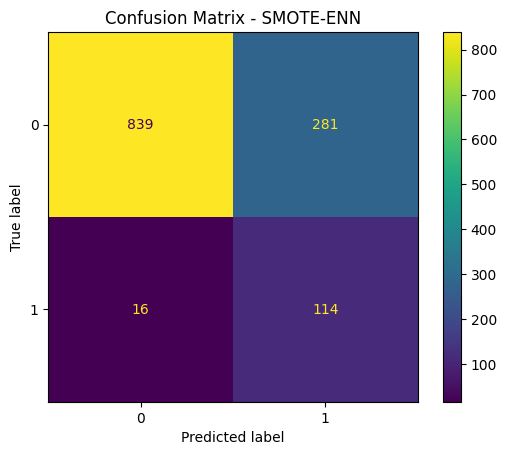

CV ROC-AUC: [0.88242617 0.86551339 0.88334907 0.84701236 0.89183293]  | Mean: 0.8740267860340312


In [8]:

def evaluate_with_resampler(resampler, name: str):
    pipe = ImbPipeline([
        ("prep", preprocess),
        ("res", resampler),
        ("clf" , LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])
    # Train-test split tetap sama
    pipe.fit(X_train, y_train)
    yhat = pipe.predict(X_test)
    yproba = pipe.predict_proba(X_test)[:,1]

    print(f"\n=== {name} ===")
    print(classification_report(y_test, yhat, digits=4))
    print("ROC-AUC:", roc_auc_score(y_test, yproba))
    ConfusionMatrixDisplay.from_predictions(y_test, yhat)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # CV (ROC-AUC)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")
    print("CV ROC-AUC:", cv_scores, " | Mean:", cv_scores.mean())

# ROS
evaluate_with_resampler(RandomOverSampler(random_state=RANDOM_STATE), "ROS (RandomOverSampler)")

# RUS
evaluate_with_resampler(RandomUnderSampler(random_state=RANDOM_STATE), "RUS (RandomUnderSampler)")

# SMOTE
evaluate_with_resampler(SMOTE(random_state=RANDOM_STATE), "SMOTE")

# SMOTE-ENN
evaluate_with_resampler(SMOTEENN(random_state=RANDOM_STATE), "SMOTE-ENN")



## 7) Perbandingan Ringkas & Tips Laporan

- Bandingkan **precision/recall/F1** pada kelas **minoritas** (biasanya label 1) dan nilai **ROC-AUC** antar metode.
- Perhatikan trade-off:
  - **ROS**: cepat, tapi bisa *overfitting*.
  - **RUS**: cepat, tapi buang banyak data mayoritas (hilang informasi).
  - **SMOTE**: menambah data sintetis (lebih kaya dari ROS), kadang sensitif terhadap *noise*.
  - **SMOTE-ENN**: cenderung lebih bersih dari SMOTE *murni*, namun lebih lambat.

**Saran screenshot untuk laporan:**
1. Grafik distribusi kelas sebelum/ sesudah (ambil dari `value_counts()` plot awal + confusion matrix tiap metode).
2. Cuplikan `classification_report` & `ROC-AUC`.
3. Jelaskan alasan memilih metode terbaik untuk dataset Anda.



## 8) Ekspor Hasil/Model (Opsional)
Contoh cara menyimpan *pipeline* terlatih dan menyimpan grafik ke file.


In [ ]:

# Contoh simpan model (opsional)
# import joblib
# joblib.dump(baseline, "baseline_model.joblib")

# Contoh simpan figur terakhir (opsional)
# plt.savefig("last_figure.png", dpi=200, bbox_inches="tight")
print("Selesai. Silakan ambil screenshot untuk laporan.")
